# Efficient data analysis in Python with ROOT

The modern interface to process datasets in ROOT files (aka [`TTree`s](https://root.cern.ch/doc/master/classTTree.html)) is [`RDataFrame`](https://root.cern.ch/doc/master/classROOT_1_1RDataFrame.html). The concept is a computation graph, which is built in a declarative manner, and executes the booked computations as efficient as possible. The following notebook provides examples of the workflow in Python.

In [1]:
import ROOT

Welcome to JupyROOT 6.22/00


## Create a dataframe from a remote dataset

This examples reads a dataset with the name `Events` remotely via the [`XRootD`](https://xrootd.slac.stanford.edu/) protocol.

In [2]:
path = 'root://eospublic.cern.ch//eos/opendata/cms/derived-data/AOD2NanoAODOutreachTool/Run2012BC_DoubleMuParked_Muons.root'
df = ROOT.RDataFrame('Events', path)

## Select events with two muons and opposite charge

We filter the dataset for events with two muons and opposite charge. The last line restricts the full dataset to a subset of the in total 66 mio. events.

In [3]:
df = df.Filter("nMuon == 2", "Events with exactly two muons")\
       .Filter("Muon_charge[0] != Muon_charge[1]", "Muons with opposite charge")\
       .Range(100000)

## Compute the invariant mass

As example for the injection of efficient C++ kernels, the computation of the invariant mass is carried out explicitely with two fourvectors. Alternatively, the ROOT utility [`ROOT::VecOps::InvariantMass`](https://root.cern.ch/doc/master/namespaceROOT_1_1VecOps.html#a2c531eae910edad48bbf7319cc6d7e58) could be used.

In [4]:
ROOT.gInterpreter.Declare(
"""
using Vec_t = const ROOT::VecOps::RVec<float>&;
float compute_mass(Vec_t pt, Vec_t eta, Vec_t phi, Vec_t mass) {
    ROOT::Math::PtEtaPhiMVector p1(pt[0], eta[0], phi[0], mass[0]);
    ROOT::Math::PtEtaPhiMVector p2(pt[1], eta[1], phi[1], mass[1]);
    return (p1 + p2).mass();
}
""")
df = df.Define("Dimuon_mass", "compute_mass(Muon_pt, Muon_eta, Muon_phi, Muon_mass)")

## Book a histogram

This cell books a histogram. Note that the computation has not started yet! Since the workflow is declarative, the computation just starts when the results are required to perform all computations in one go as optimized as possible.

In [5]:
hist = df.Histo1D(("hist", ";m_{#mu#mu} (GeV);N_{Events}", 5000, 2, 200), "Dimuon_mass")

## Book a cutflow report

In addition, we book a cutflow report, which is shown below the plot.

In [6]:
report = df.Report()

## Plot the result

Note that drawing the histogram accessed the object, which also triggers the actual event loop.

In [7]:
ROOT.gStyle.SetOptStat(0); ROOT.gStyle.SetTextFont(42)
c = ROOT.TCanvas("c", "", 800, 700)
c.SetLogx(); c.SetLogy()
hist.Draw()

label = ROOT.TLatex(); label.SetNDC(True)
label.SetTextSize(0.040); label.DrawLatex(0.100, 0.920, "#bf{CMS Open Data}")
label.SetTextSize(0.030); label.DrawLatex(0.630, 0.920, "#sqrt{s} = 8 TeV, L_{int} = 11.6 fb^{-1}");

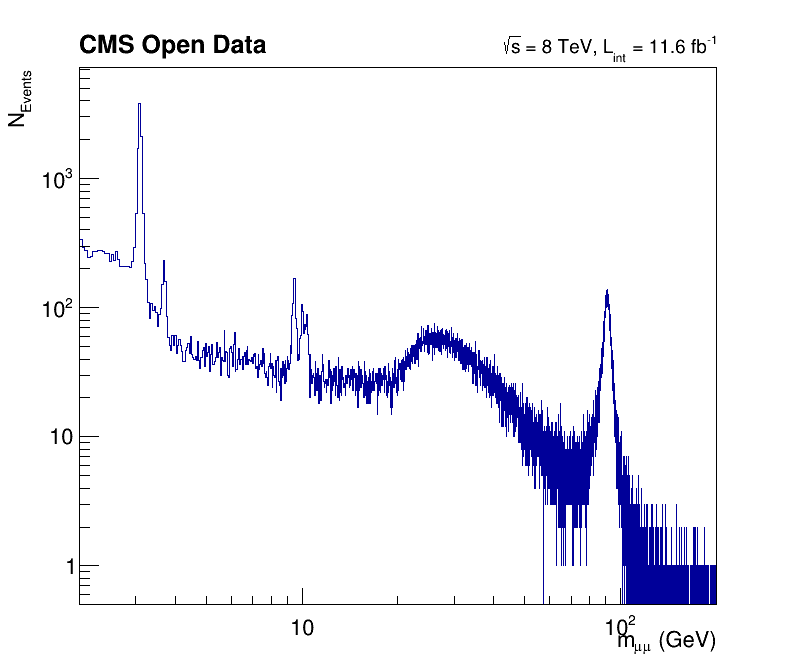

In [8]:
c.Draw()

## Print the cutflow report

Here you can inspect the number of events actually read and how many ended up in the histogram.

In [9]:
report.Print()

Events with exactly two muons: pass=131936     all=270077     -- eff=48.85 % cumulative eff=48.85 %
Muons with opposite charge: pass=100000     all=131936     -- eff=75.79 % cumulative eff=37.03 %


# Other example analyses

The following part of the notebook highlights example analyses in Python using a workflow similar to the example above, all freely accessbile thanks to open source and open data!

## Higgs to four leptons analysis using CMS Open Data

![](https://root.cern.ch/doc/v622/pict1_df103_NanoAODHiggsAnalysis.C.png)

[Link to analysis and notebooks](https://root.cern.ch/doc/v622/df103__NanoAODHiggsAnalysis_8py.html)

## Higgs to two photons analysis using ATLAS Open Data

![](https://root.cern.ch/doc/v622/pict1_df104_HiggsToTwoPhotons.py.png)

[Link to analysis and notebooks](https://root.cern.ch/doc/v622/df104__HiggsToTwoPhotons_8py.html)

## W boson analysis using ATLAS Open Data

![](https://root.cern.ch/doc/v622/pict1_df105_WBosonAnalysis.py.png)

[Link to analysis and notebooks](https://root.cern.ch/doc/v622/df105__WBosonAnalysis_8py.html)

## Higgs to four leptons analysis using ATLAS Open Data

![](https://root.cern.ch/doc/v622/pict1_df106_HiggsToFourLeptons.py.png)

[Link to analysis and notebooks](https://root.cern.ch/doc/v622/df106__HiggsToFourLeptons_8py.html)